In [4]:
# Requires the following packages:
# %pip install datasets

In [1]:
from datasets import load_dataset
import librosa
import matplotlib.pyplot as plt
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from datasets import Audio
from datasets import concatenate_datasets
from datasets import load_from_disk
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from datasets import DatasetDict
import tensorflow as tf
from tensorflow.keras import layers, models, Input

ages = ["teens", "twenties", "thirties", "fourties", "fifties", "sixties"]
genders = ["female_feminine", "male_masculine"]
genders_show = ["F", "M"]

labels = [f"{x1}_{x2}" for x1 in genders_show for x2 in ages]

print(tf.config.list_physical_devices('GPU'))
labels

2024-05-17 15:02:57.753103: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 15:02:59.302819: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-17 15:03:00.560561: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 15:03:00.860212: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 15:03:00.860572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

['F_teens',
 'F_twenties',
 'F_thirties',
 'F_fourties',
 'F_fifties',
 'F_sixties',
 'M_teens',
 'M_twenties',
 'M_thirties',
 'M_fourties',
 'M_fifties',
 'M_sixties']

# Loading dataset

In [6]:
from datasets import load_dataset

# this downloads the dataset
# almost 135GB

while True:
    try:
        cv_17 = load_dataset("mozilla-foundation/common_voice_17_0", "es", split="train", trust_remote_code=True)
        break
    except:
        pass


In [ ]:
cv_17

Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
    num_rows: 336846
})

In [ ]:
example = cv_17[0]

example

{'client_id': '47d08a162055906056c71957974d5ae33e445107784c684b5077f3dbf06db36ec3c8388a54e7b0171d11daf21c565cedeea8ea57b05b14f5f5e419c9b26784a3',
 'path': '/home/wolf/.cache/huggingface/datasets/downloads/extracted/f5c077e7a2295e695208204ea8199c31cff3f4d5693a2914c08b442289f59878/es_train_0/common_voice_es_18933583.mp3',
 'audio': {'path': '/home/wolf/.cache/huggingface/datasets/downloads/extracted/f5c077e7a2295e695208204ea8199c31cff3f4d5693a2914c08b442289f59878/es_train_0/common_voice_es_18933583.mp3',
  'array': array([ 0.00000000e+00,  3.05721540e-13, -5.25745896e-15, ...,
         -7.41100479e-08,  6.93593734e-08,  2.23998313e-07]),
  'sampling_rate': 48000},
 'sentence': 'la vi solo un instante',
 'up_votes': 2,
 'down_votes': 0,
 'age': 'thirties',
 'gender': 'male_masculine',
 'accent': 'México',
 'locale': 'es',
 'segment': '',
 'variant': ''}

# Drawing waveform and espectrogram of an example from the database

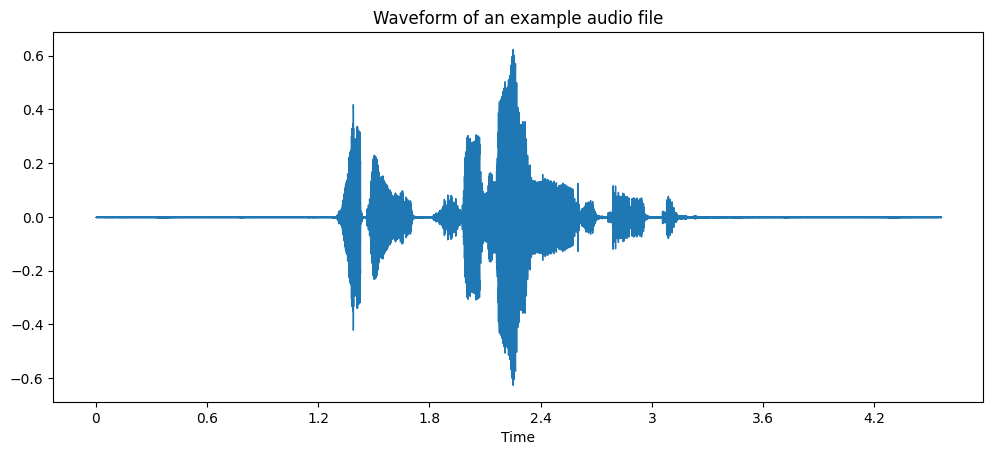

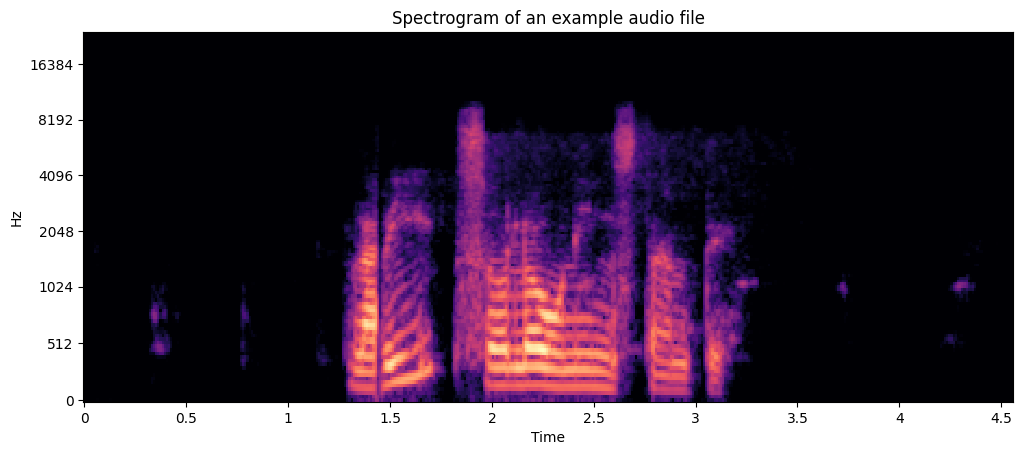

In [ ]:
array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
plt.title("Waveform of an example audio file")
librosa.display.waveshow(array, sr=sampling_rate)

# show spectrogram

S = librosa.feature.melspectrogram(y=array, sr=sampling_rate)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
plt.title("Spectrogram of an example audio file")
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sampling_rate)

ipd.Audio(example["audio"]["array"], rate=example["audio"]["sampling_rate"])

# Preprocessing

In [ ]:
cv_17 = cv_17.remove_columns(['client_id', 'sentence', 'up_votes', 'down_votes', 'accent', 'locale', 'segment', 'variant'])

### Remove any samples with no gender or no age

In [ ]:
# in the age column (string) remove any None, empty or whitespace-only values

def is_string_valid(input_string):
    return input_string and input_string.strip()

In [ ]:
cv_17 = cv_17.filter(is_string_valid, input_columns="age")
cv_17 = cv_17.filter(is_string_valid, input_columns="gender")
cv_17

Dataset({
    features: ['path', 'audio', 'age', 'gender'],
    num_rows: 296535
})

### Remove any samples that do not belong in any of the ages groups or gender groups defined

In [ ]:
def is_age_valid(input_str):
    return input_str in ages

def is_gender_valid(input_str):
    return input_str in genders

In [ ]:
cv_17 = cv_17.filter(is_age_valid, input_columns="age")
cv_17 = cv_17.filter(is_gender_valid, input_columns="gender")
cv_17

Dataset({
    features: ['path', 'audio', 'age', 'gender'],
    num_rows: 296339
})

### Map gender and age and create label column

In [ ]:
# map age brackets to integers

def map_x1_and_x2(cur_sample):
    return { "label" : labels.index(f"{genders_show[genders.index(cur_sample['gender'])]}_{cur_sample['age']}") }

In [ ]:

cv_17 = cv_17.map(map_x1_and_x2, remove_columns=['age', 'gender'])
cv_17

Dataset({
    features: ['path', 'audio', 'label'],
    num_rows: 296339
})

### Remove any samples with duration longer than 10 seconds

In [ ]:
MAX_DURATION_IN_SECONDS = 10.0

def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [ ]:
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in cv_17["path"]]
cv_17 = cv_17.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
cv_17 = cv_17.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
cv_17 = cv_17.remove_columns(["duration", "path"])
cv_17

Dataset({
    features: ['audio', 'label'],
    num_rows: 295930
})

### Create training, validation, and test dataset

In [ ]:
# Select only a subset of the dataset
# 65%  2667.5
# 15% 615.6
# 20% 820.8

from datasets import concatenate_datasets

MIN_SIZE = 500
SEED = 768

ds_gen = []
#first four labels
for l in labels[:4]:
    bracket = cv_17.filter(lambda x: x["label"] == labels.index(l))
    bracket = bracket.train_test_split(test_size=MIN_SIZE, shuffle=True, seed=SEED)
    ds_gen.append(bracket["test"])

ds_gen = concatenate_datasets(ds_gen)
ds_gen.save_to_disk("reduced_dataset_1")
ds_gen

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'label'],
    num_rows: 2000
})

In [ ]:
# Select only a subset of the dataset
# 65%  2667.5
# 15% 615.6
# 20% 820.8

from datasets import concatenate_datasets

MIN_SIZE = 500
SEED = 768

ds_gen = []
#from label 5 until 8
for l in labels[4:8]:
    bracket = cv_17.filter(lambda x: x["label"] == labels.index(l))
    bracket = bracket.train_test_split(test_size=MIN_SIZE, shuffle=True, seed=SEED)
    ds_gen.append(bracket["test"])

ds_gen = concatenate_datasets(ds_gen)
ds_gen.save_to_disk("reduced_dataset_2")
ds_gen

Filter:   0%|          | 0/295930 [00:00<?, ? examples/s]

Filter:   0%|          | 0/295930 [00:00<?, ? examples/s]

Filter:   0%|          | 0/295930 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'label'],
    num_rows: 2000
})

In [ ]:
# Select only a subset of the dataset
# 65%  2667.5
# 15% 615.6
# 20% 820.8

from datasets import concatenate_datasets

MIN_SIZE = 500
SEED = 768

ds_gen = []
#last four labels
for l in labels[8:]:
    bracket = cv_17.filter(lambda x: x["label"] == labels.index(l))
    bracket = bracket.train_test_split(test_size=MIN_SIZE, shuffle=True, seed=SEED)
    ds_gen.append(bracket["test"])

ds_gen = concatenate_datasets(ds_gen)
ds_gen.save_to_disk("reduced_dataset_3")
ds_gen

Filter:   0%|          | 0/295930 [00:00<?, ? examples/s]

Filter:   0%|          | 0/295930 [00:00<?, ? examples/s]

Filter:   0%|          | 0/295930 [00:00<?, ? examples/s]

Filter:   0%|          | 0/295930 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'label'],
    num_rows: 2000
})

In [ ]:
ds_1 = load_from_disk("reduced_dataset_1")
ds_2 = load_from_disk("reduced_dataset_2")
ds_3 = load_from_disk("reduced_dataset_3")

cv_17 = concatenate_datasets([ds_1, ds_2, ds_3])
cv_17.save_to_disk("reduced_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/6000 [00:00<?, ? examples/s]

In [2]:
from datasets import load_from_disk

cv_17 = load_from_disk("reduced_dataset")
cv_17

Dataset({
    features: ['audio', 'label'],
    num_rows: 6000
})

In [3]:
# Select only a subset of the dataset. 2060
# 60%  1236
# 20% 412
# 20% 412

from datasets import concatenate_datasets

MIN_SIZE = 258
SEED = 768

train_gen = []
val_gen = []
test_gen = []
for l in labels:
    bracket = cv_17.filter(lambda x: x["label"] == labels.index(l))
    bracket = bracket.train_test_split(test_size=MIN_SIZE, shuffle=True, seed=SEED)
    temp1 = bracket["test"].train_test_split(test_size=102, shuffle=True, seed=SEED)
    train_gen.append(temp1["train"])
    temp2 = temp1["test"].train_test_split(test_size=51, shuffle=True, seed=SEED)
    val_gen.append(temp2["train"])
    test_gen.append(temp2["test"])
    

train_gen = concatenate_datasets(train_gen)
val_gen = concatenate_datasets(val_gen)
test_gen = concatenate_datasets(test_gen)

# Create DatasetDict

ds_dict = DatasetDict({
    "train": train_gen,
    "val": val_gen,
    "test": test_gen
})

ds_dict.save_to_disk("dataset_fr")
ds_dict

Saving the dataset (0/1 shards):   0%|          | 0/1872 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/612 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/612 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 1872
    })
    val: Dataset({
        features: ['audio', 'label'],
        num_rows: 612
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 612
    })
})

In [3]:
# Select only a subset of the dataset. 1030
# 60%  618
# 20% 206
# 20% 206

from datasets import concatenate_datasets

MIN_SIZE = 86
SEED = 768

train_gen = []
val_gen = []
test_gen = []
for l in labels:
    bracket = cv_17.filter(lambda x: x["label"] == labels.index(l))
    bracket = bracket.train_test_split(test_size=MIN_SIZE, shuffle=True, seed=SEED)
    temp1 = bracket["test"].train_test_split(test_size=34, shuffle=True, seed=SEED)
    train_gen.append(temp1["train"])
    temp2 = temp1["test"].train_test_split(test_size=17, shuffle=True, seed=SEED)
    val_gen.append(temp2["train"])
    test_gen.append(temp2["test"])
    

train_gen = concatenate_datasets(train_gen)
val_gen = concatenate_datasets(val_gen)
test_gen = concatenate_datasets(test_gen)

# Create DatasetDict

ds_dict = DatasetDict({
    "train": train_gen,
    "val": val_gen,
    "test": test_gen
})

ds_dict.save_to_disk("dataset_fr")
ds_dict

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/624 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/204 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/204 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 624
    })
    val: Dataset({
        features: ['audio', 'label'],
        num_rows: 204
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 204
    })
})

In [3]:
from datasets import load_from_disk

cv_17 = load_from_disk("dataset_fr")
cv_17

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 1872
    })
    val: Dataset({
        features: ['audio', 'label'],
        num_rows: 612
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 612
    })
})

### Adjust sample rate of all examples to 16Khz

In [5]:
from datasets import Audio

cv_17['train'] = cv_17['train'].cast_column("audio", Audio(sampling_rate=16_000))
cv_17['val'] = cv_17['val'].cast_column("audio", Audio(sampling_rate=16_000))
cv_17['test'] = cv_17['test'].cast_column("audio", Audio(sampling_rate=16_000))

{'audio': {'path': 'common_voice_es_34035344.mp3', 'array': array([-8.73114914e-11, -2.91038305e-11, -8.73114914e-11, ...,
        4.02797014e-07,  1.62329525e-06, -5.59259206e-07]), 'sampling_rate': 16000}, 'label': 0}


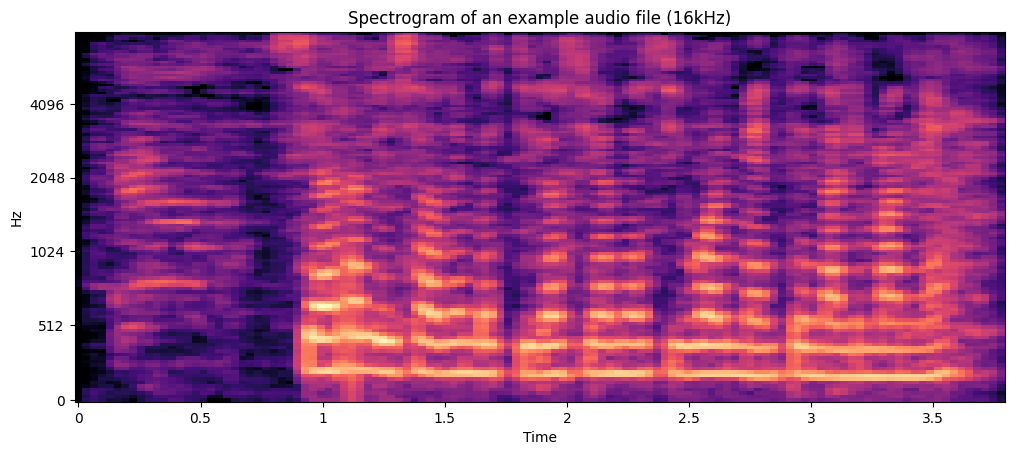

In [6]:
example = cv_17['train'][0]

print(example)

array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

# show spectrogram

S = librosa.feature.melspectrogram(y=array, sr=sampling_rate)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
plt.title("Spectrogram of an example audio file (16kHz)")
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sampling_rate)

ipd.Audio(cv_17['train'][0]["audio"]["array"], rate=cv_17['train'][0]["audio"]["sampling_rate"])

# Spectrogram generation

In [14]:
import matplotlib.pyplot as plt
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import librosa.display
import numpy as np

def create_spectrogram(audio, sr):
    fig = plt.figure(figsize=(2.4, 2.4), dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')

    S = librosa.feature.melspectrogram(y=audio, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr)
    canvas = FigureCanvas(fig)
    canvas.draw()
    # greyscale
    img = np.array(canvas.renderer.buffer_rgba())
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    plt.close(fig)

    return img

In [8]:
cv_17['train'] = cv_17['train'].map(
    lambda example: {
        'spectrogram': create_spectrogram(example['audio']['array'], example['audio']['sampling_rate'])
        }, 
        remove_columns=['audio'],
)

cv_17['val'] = cv_17['val'].map(
    lambda example: {
        'spectrogram': create_spectrogram(example['audio']['array'], example['audio']['sampling_rate'])
        }, 
        remove_columns=['audio'],
)

cv_17['test'] = cv_17['test'].map(
    lambda example: {
        'spectrogram': create_spectrogram(example['audio']['array'], example['audio']['sampling_rate'])
        }, 
        remove_columns=['audio'],
)

cv_17.save_to_disk("spectrogram_dataset")
cv_17

Map:   0%|          | 0/1872 [00:00<?, ? examples/s]

Map:   0%|          | 0/612 [00:00<?, ? examples/s]

Map:   0%|          | 0/612 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/1872 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/612 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/612 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'spectrogram'],
        num_rows: 1872
    })
    val: Dataset({
        features: ['label', 'spectrogram'],
        num_rows: 612
    })
    test: Dataset({
        features: ['label', 'spectrogram'],
        num_rows: 612
    })
})

In [2]:
cv_17 = load_from_disk("spectrogram_dataset_2")
print(np.array(cv_17['train'][0]['spectrogram']).shape)
cv_17

(240, 240, 3)


DatasetDict({
    train: Dataset({
        features: ['label', 'spectrogram'],
        num_rows: 3600
    })
    val: Dataset({
        features: ['label', 'spectrogram'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['label', 'spectrogram'],
        num_rows: 1200
    })
})

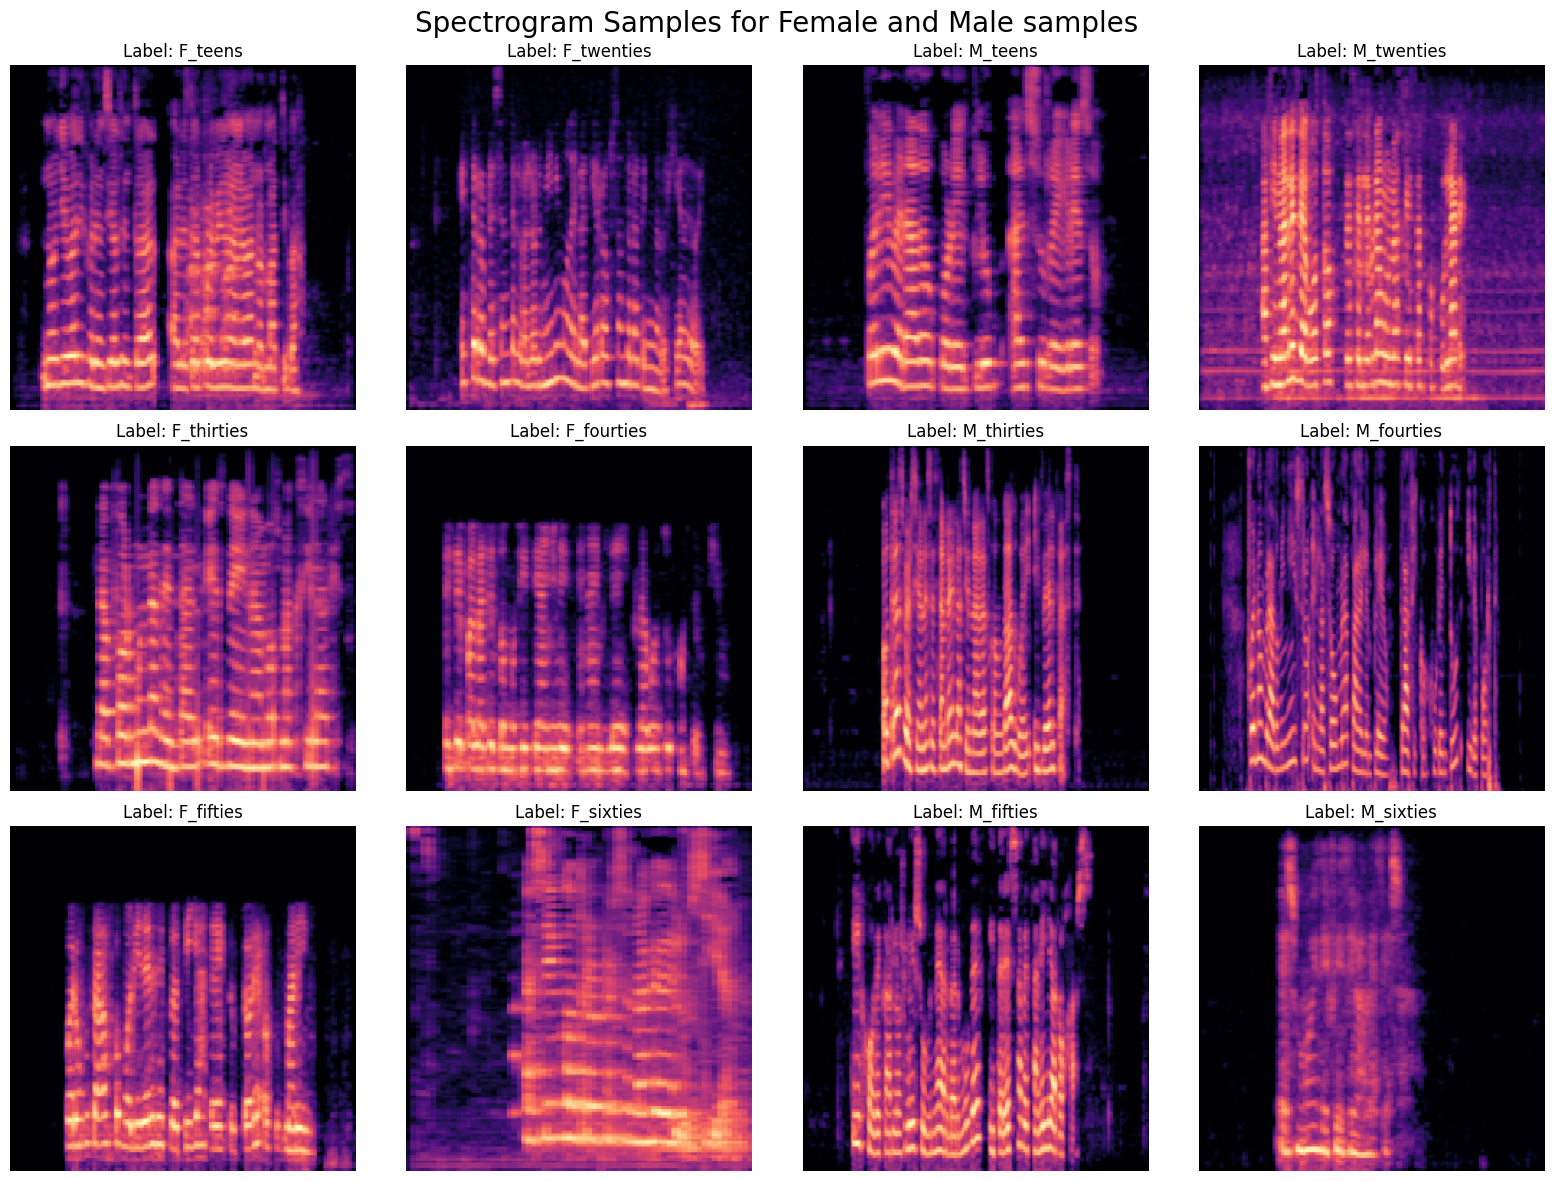

In [3]:
# now that we have the pictures as in RGB of the spectrogram, show 4 random examples

cv_17_train = cv_17['train']

fig, axs = plt.subplots(3, 4, figsize=(16, 12))  # Adjust the figure size to better fit square subplots
num_samples_per_label = 52

# First 6 columns for female labels
for i, label in enumerate(labels[:6]):
    random_index = np.random.randint(i * num_samples_per_label, (i + 1) * num_samples_per_label)
    example = cv_17_train[random_index]
    ax = axs[i // 2, i % 2]
    ax.imshow(example['spectrogram'])
    ax.axis('off')
    ax.set_title(f"Label: {label}")

# Next 6 columns for male labels
for i, label in enumerate(labels[6:], start=6):
    random_index = np.random.randint(i * num_samples_per_label, (i + 1) * num_samples_per_label)
    example = cv_17_train[random_index]
    ax = axs[(i-6) // 2, (i-6) % 2 + 2]
    ax.imshow(example['spectrogram'])
    ax.axis('off')
    ax.set_title(f"Label: {label}")

fig.suptitle('Spectrogram Samples for Female and Male samples', x=0.5, y=0.98, fontsize=20)  # Single title for the entire graph

plt.tight_layout()
plt.show()

### Create batches

In [3]:
import tensorflow as tf

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Extract the spectrograms and labels from the Hugging Face datasets
print("TRAINING SET")
train_ds = tf.data.Dataset.from_tensor_slices((cv_17['train']['spectrogram'], cv_17['train']['label']))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).cache().repeat().prefetch(buffer_size=AUTOTUNE)

print("VALIDATION SET")
val_ds = tf.data.Dataset.from_tensor_slices((cv_17['val']['spectrogram'], cv_17['val']['label']))
val_ds = val_ds.shuffle(1000).batch(BATCH_SIZE).cache().repeat().prefetch(buffer_size=AUTOTUNE)

print("TEST SET")
test_ds = tf.data.Dataset.from_tensor_slices((cv_17['test']['spectrogram'], cv_17['test']['label']))
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

TRAINING SET


2024-05-17 15:29:58.738698: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 15:29:58.742558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 15:29:58.742703: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

VALIDATION SET


2024-05-17 15:38:53.062839: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 829440000 exceeds 10% of free system memory.


TEST SET


2024-05-17 15:47:44.847039: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 829440000 exceeds 10% of free system memory.


# Create model

In [120]:
from tensorflow.keras import layers, models, Input

def preprocess_block(inputs, block_name):
    with tf.name_scope(block_name):
        # from 3 channels to 1 channel, rgb to greyscale
        x = layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x), name=f"{block_name}_greyscale")(inputs)
        x = layers.Resizing(64, 64)(x)
        x = layers.Rescaling(1./255)(x)
    return x

def flb_block(inputs, block_name):
    with tf.name_scope(block_name):
        x = layers.Conv2D(120, (9, 9), strides=(2, 2), activation='relu', padding='same', name=f"{block_name}_conv1")(inputs)
        x = layers.BatchNormalization(name=f"{block_name}_batch1")(x)
        x = layers.MaxPooling2D((2, 2), strides=(2, 2), name=f"{block_name}_maxpool1")(x)
        x = layers.Conv2D(256, (5, 5), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv2")(x)
        x = layers.MaxPooling2D((2, 2), strides=(2, 2), name=f"{block_name}_maxpool2")(x)
        x = layers.Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv3")(x)
        x = layers.BatchNormalization(name=f"{block_name}_batch2")(x)
    return x

def mam_block(inputs, block_name):
    with tf.name_scope(block_name):
        ta = layers.Conv2D(64, (1, 9), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv1_ta")(inputs)
        ta = layers.Conv2D(64, (1, 3), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv2_ta")(ta)  
        ta = layers.Conv2D(64, (1, 3), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv3_ta")(ta)
        ta = layers.BatchNormalization(name=f"{block_name}_batchn_ta")(ta)
        fa = layers.Conv2D(64, (9, 1), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv1_fa")(inputs)
        fa = layers.Conv2D(64, (3, 1), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv2_fa")(fa)
        fa = layers.Conv2D(64, (3, 1), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv3_fa")(fa)
        fa = layers.BatchNormalization(name=f"{block_name}_batchn_fa")(fa)
        x = layers.Concatenate(name=f"{block_name}_concat_ta_fa")([ta, fa])
        x = layers.BatchNormalization(name=f"{block_name}_batchn_concat_ta_fa")(x)
        x = layers.Concatenate(name=f"{block_name}_concat_x_inputs")([x, inputs])
    return x

def fcn_block(inputs, block_name):
    with tf.name_scope(block_name):
        x = layers.Flatten(name="FLATTEN")(inputs)
        x = layers.Dense(80, activation='relu', name="DENSE_1")(x)
        x = layers.BatchNormalization(name="BATCH_1")(x)
        x = layers.Dropout(0.5, name="DROPOUT_1")(x)
        x = layers.Dense(12, activation='softmax', name="DENSE_2")(x)
    return x

In [121]:
input_layer = Input(shape=(None, None, 3))
prepro = preprocess_block(input_layer, "preprocess")
FLB1 = flb_block(prepro, "FLB_1")
MAM = mam_block(FLB1, "MAM")
FLB2 = flb_block(MAM, "FLB_2")
FCN = fcn_block(FLB2, "FCN")

model = models.Model(inputs=input_layer, outputs=FCN)

model.summary()

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocess_greysca… │ (None, None,      │          0 │ input_layer_24[0… │
│ (Lambda)            │ None, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_24         │ (None, 64, 64, 1) │          0 │ preprocess_greys… │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_24        │ (None, 64, 64, 1) │          0 │ resizing_24[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FLB_1_conv1         │ (None, 32, 32,    │      9,840 │ rescaling_24[0][… │
│ (Conv2D)            │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FLB_1_batch1        │ (None, 32, 32,    │        480 │ FLB_1_conv1[0][0] │
│ (BatchNormalizatio… │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FLB_1_maxpool1      │ (None, 16, 16,    │          0 │ FLB_1_batch1[0][… │
│ (MaxPooling2D)      │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FLB_1_conv2         │ (None, 16, 16,    │    768,256 │ FLB_1_maxpool1[0… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FLB_1_maxpool2      │ (None, 8, 8, 256) │          0 │ FLB_1_conv2[0][0] │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FLB_1_conv3         │ (None, 8, 8, 384) │    885,120 │ FLB_1_maxpool2[0… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FLB_1_batch2        │ (None, 8, 8, 384) │      1,536 │ FLB_1_conv3[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAM_conv1_ta        │ (None, 8, 8, 64)  │    221,248 │ FLB_1_batch2[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAM_conv1_fa        │ (None, 8, 8, 64)  │    221,248 │ FLB_1_batch2[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAM_conv2_ta        │ (None, 8, 8, 64)  │     12,352 │ MAM_conv1_ta[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAM_conv2_fa        │ (None, 8, 8, 64)  │     12,352 │ MAM_conv1_fa[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAM_conv3_ta        │ (None, 8, 8, 64)  │     12,352 │ MAM_conv2_ta[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAM_conv3_fa        │ (None, 8, 8, 64)  │     12,352 │ MAM_conv2_fa[0][

 Total params: 8,822,404 (33.65 MB)

 Trainable params: 8,819,716 (33.64 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [122]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(
    train_ds,
    steps_per_epoch=cv_17['train'].num_rows // BATCH_SIZE,
    epochs=120,
    validation_data=val_ds,
    validation_steps=cv_17['val'].num_rows // BATCH_SIZE,
    verbose=2
)

Epoch 1/120
112/112 - 13s - 116ms/step - accuracy: 0.2547 - loss: 2.5125 - val_accuracy: 0.0836 - val_loss: 3.7141
Epoch 2/120
112/112 - 10s - 87ms/step - accuracy: 0.3293 - loss: 2.1807 - val_accuracy: 0.1053 - val_loss: 4.5185
Epoch 3/120
112/112 - 5s - 47ms/step - accuracy: 0.4002 - loss: 1.8793 - val_accuracy: 0.1550 - val_loss: 3.1479
Epoch 4/120
112/112 - 5s - 48ms/step - accuracy: 0.4753 - loss: 1.6686 - val_accuracy: 0.2885 - val_loss: 1.9789
Epoch 5/120
112/112 - 5s - 47ms/step - accuracy: 0.4683 - loss: 1.6175 - val_accuracy: 0.3519 - val_loss: 1.9661
Epoch 6/120
112/112 - 5s - 49ms/step - accuracy: 0.5303 - loss: 1.4642 - val_accuracy: 0.3510 - val_loss: 2.1614
Epoch 7/120
112/112 - 6s - 51ms/step - accuracy: 0.5706 - loss: 1.3434 - val_accuracy: 0.3570 - val_loss: 2.1544
Epoch 8/120
112/112 - 6s - 50ms/step - accuracy: 0.6172 - loss: 1.2068 - val_accuracy: 0.4144 - val_loss: 1.7387
Epoch 9/120
112/112 - 5s - 49ms/step - accuracy: 0.6696 - loss: 1.0504 - val_accuracy: 0.2937

In [123]:
history = model.fit(
    train_ds,
    steps_per_epoch=cv_17['train'].num_rows // BATCH_SIZE,
    epochs=120, 
    validation_data=val_ds,
    validation_steps=cv_17['val'].num_rows // BATCH_SIZE,
    verbose=2
)

Epoch 1/120
112/112 - 17s - 150ms/step - accuracy: 0.2182 - loss: 2.8499 - val_accuracy: 0.0836 - val_loss: 5.1738
Epoch 2/120
112/112 - 13s - 113ms/step - accuracy: 0.2124 - loss: 2.6373 - val_accuracy: 0.0848 - val_loss: 5.7405
Epoch 3/120
112/112 - 7s - 59ms/step - accuracy: 0.2508 - loss: 2.4159 - val_accuracy: 0.0925 - val_loss: 4.8414
Epoch 4/120
112/112 - 7s - 59ms/step - accuracy: 0.2859 - loss: 2.2324 - val_accuracy: 0.1130 - val_loss: 5.1811
Epoch 5/120
112/112 - 6s - 58ms/step - accuracy: 0.3038 - loss: 2.1138 - val_accuracy: 0.2080 - val_loss: 2.8209
Epoch 6/120
112/112 - 7s - 59ms/step - accuracy: 0.3559 - loss: 1.9894 - val_accuracy: 0.1473 - val_loss: 3.9817
Epoch 7/120
112/112 - 7s - 58ms/step - accuracy: 0.3949 - loss: 1.8333 - val_accuracy: 0.2175 - val_loss: 2.8677
Epoch 8/120
112/112 - 7s - 59ms/step - accuracy: 0.3941 - loss: 1.7987 - val_accuracy: 0.2089 - val_loss: 3.4377
Epoch 9/120
112/112 - 6s - 58ms/step - accuracy: 0.4305 - loss: 1.6927 - val_accuracy: 0.208

In [124]:
model.save_weights('./checkpoints/model_grey.weights.h5')

In [125]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

def plot_learning_curves(history, model_name):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss for {model_name}')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy for {model_name}')

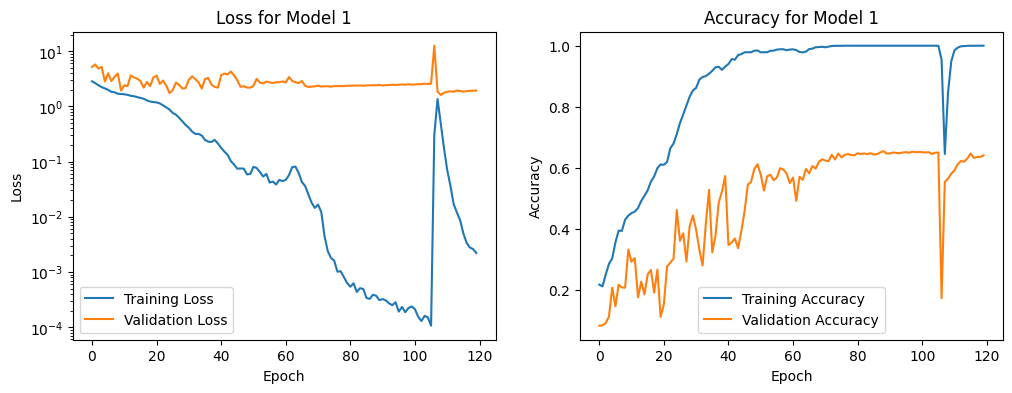

In [126]:
plot_learning_curves(history, 'Model 1')

In [127]:
def print_confusion_matrix_and_report(model, dataset, model_name):
    # Get the true labels and the model's predictions
    y_true = np.concatenate([np.expand_dims(y.numpy(), 0) for x, y in dataset.unbatch()])
    y_pred = np.argmax(model.predict(dataset), axis=1)
    
    # Create a mapping from numeric labels to vowels
    label_mapping = {i: labels[i] for i in range(12)}
    
    # Replace the numeric labels with the corresponding vowels
    y_true = np.vectorize(label_mapping.get)(y_true)
    y_pred = np.vectorize(label_mapping.get)(y_pred)
    
    # Create the ConfusionMatrixDisplay and plot it
    cm = confusion_matrix(y_true, y_pred, labels=list(label_mapping.values()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
    disp.plot()
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xticks(rotation=45)
    plt.figure(figsize=(22, 22), dpi=200)
    
    # Print the classification report
    print(f'Classification Report for {model_name}:')
    print(classification_report(y_true, y_pred))

In [128]:
# Evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Model, accuracy: {:5.2f}%".format(100 * acc))
print("Model, loss: {:5.2f}%".format(100 * loss))

38/38 - 1s - 19ms/step - accuracy: 0.6608 - loss: 1.7866
Model, accuracy: 66.08%
Model, loss: 178.66%


2024-05-17 19:34:48.621470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Classification Report for Model 1:
              precision    recall  f1-score   support

   F_fifties       0.67      0.66      0.67       100
  F_fourties       0.75      0.71      0.73       100
   F_sixties       0.85      0.95      0.90       100
     F_teens       0.65      0.70      0.67       100
  F_thirties       0.63      0.63      0.63       100
  F_twenties       0.73      0.55      0.63       100
   M_fifties       0.76      0.75      0.75       100
  M_fourties       0.55      0.48      0.51       100
   M_sixties       0.95      0.95      0.95       100
     M_teens       0.59      0.57      0.58       100
  M_thirties       0.37      0.50      0.43       100
  M_twenties       0.51      0.48      0.49       100

    accuracy                           0.66      1200
   macro avg       0.67      0.66      0.66      1200
weighted avg       0.67      0.66      0.66      1200



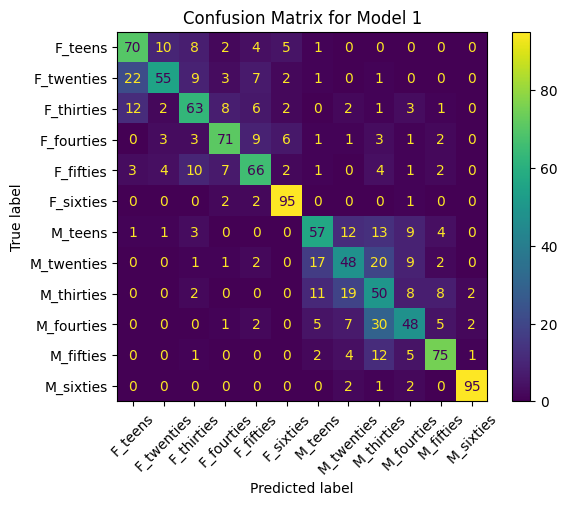

<Figure size 4400x4400 with 0 Axes>

In [129]:
print_confusion_matrix_and_report(model, test_ds, 'Model 1')

In [130]:
KERAS_MODEL_PATH = 'tf_model_1'

model.export(KERAS_MODEL_PATH)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(KERAS_MODEL_PATH) # path to the SavedModel directory

tflite_model = converter.convert()

# Save the model.
with open('model_1.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: tf_model_1/assets


INFO:tensorflow:Assets written to: tf_model_1/assets


Saved artifact at 'tf_model_1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor_574')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  123201276314720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123201276314544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123201276317008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123201276317360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123201276316480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123201276316656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123201276287456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123201276287280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123201276269840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123201276269664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1232012762721

W0000 00:00:1715988893.019349    3941 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1715988893.019381    3941 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-05-17 19:34:53.019740: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: tf_model_1
2024-05-17 19:34:53.022403: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-17 19:34:53.022429: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: tf_model_1
2024-05-17 19:34:53.063502: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-05-17 19:34:53.276160: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: tf_model_1
2024-05-17 19:34:53.349723: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 329992 microseconds.


# Create model 2

In [131]:
def flb_block_2(inputs, block_name):
    with tf.name_scope(block_name):
        x = layers.Conv2D(120, (9, 9), strides=(2, 2), activation='relu', padding='same', name=f"{block_name}_conv1")(inputs)
        x = layers.BatchNormalization(name=f"{block_name}_batch1")(x)
        x = layers.MaxPooling2D((2, 2), strides=(2, 2), name=f"{block_name}_maxpool1")(x)
#        x = layers.Conv2D(256, (5, 5), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv2")(x)
#        x = layers.MaxPooling2D((2, 2), strides=(2, 2), name=f"{block_name}_maxpool2")(x)
#        x = layers.Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv3")(x)
#        x = layers.BatchNormalization(name=f"{block_name}_batch2")(x)
    return x

def mam_block_2(inputs, block_name):
    with tf.name_scope(block_name):
        ta = layers.Conv2D(64, (1, 9), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv1_ta")(inputs)
        ta = layers.Conv2D(64, (1, 3), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv2_ta")(ta)  
#        ta = layers.Conv2D(64, (1, 3), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv3_ta")(ta)
        ta = layers.BatchNormalization(name=f"{block_name}_batchn_ta")(ta)
        fa = layers.Conv2D(64, (9, 1), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv1_fa")(inputs)
        fa = layers.Conv2D(64, (3, 1), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv2_fa")(fa)
#        fa = layers.Conv2D(64, (3, 1), strides=(1, 1), activation='relu', padding='same', name=f"{block_name}_conv3_fa")(fa)
        fa = layers.BatchNormalization(name=f"{block_name}_batchn_fa")(fa)
        x = layers.Concatenate(name=f"{block_name}_concat_ta_fa")([ta, fa])
        x = layers.BatchNormalization(name=f"{block_name}_batchn_concat_ta_fa")(x)
        x = layers.Concatenate(name=f"{block_name}_concat_x_inputs")([x, inputs])
    return x

In [132]:
input_layer = Input(shape=(None, None, 3))
prepro = preprocess_block(input_layer, "preprocess")
FLB1 = flb_block_2(prepro, "FLB_1")
MAM = mam_block_2(FLB1, "MAM")
FLB2 = flb_block_2(MAM, "FLB_2")
FCN = fcn_block(FLB2, "FCN")

model2 = models.Model(inputs=input_layer, outputs=FCN)

model2.summary()

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocess_greysca… │ (None, None,      │          0 │ input_layer_25[0… │
│ (Lambda)            │ None, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_25         │ (None, 64, 64, 1) │          0 │ preprocess_greys… │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_25        │ (None, 64, 64, 1) │          0 │ resizing_25[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FLB_1_conv1         │ (None, 32, 32,    │      9,840 │ rescaling_25[0][… │
│ (Conv2D)            │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FLB_1_batch1        │ (None, 32, 32,    │        480 │ FLB_1_conv1[0][0] │
│ (BatchNormalizatio… │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FLB_1_maxpool1      │ (None, 16, 16,    │          0 │ FLB_1_batch1[0][… │
│ (MaxPooling2D)      │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAM_conv1_ta        │ (None, 16, 16,    │     69,184 │ FLB_1_maxpool1[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAM_conv1_fa        │ (None, 16, 16,    │     69,184 │ FLB_1_maxpool1[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAM_conv2_ta        │ (None, 16, 16,    │     12,352 │ MAM_conv1_ta[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAM_conv2_fa        │ (None, 16, 16,    │     12,352 │ MAM_conv1_fa[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAM_batchn_ta       │ (None, 16, 16,    │        256 │ MAM_conv2_ta[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAM_batchn_fa       │ (None, 16, 16,    │        256 │ MAM_conv2_fa[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAM_concat_ta_fa    │ (None, 16, 16,    │          0 │ MAM_batchn_ta[0]… │
│ (Concatenate)       │ 128)              │            │ MAM_batchn_fa[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAM_batchn_concat_… │ (None, 16, 16,    │        512 │ MAM_concat_ta_fa… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAM_concat_x_inputs │ (None, 16, 16,    │          0 │ MAM_batchn_conca… │
│ (Concatenate)       │ 248)              │            │ FLB_1_maxpool1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FLB_2_conv1         │ (None, 8, 8, 120) │  2,410,680 │ MAM_concat_x_inp

 Total params: 2,740,548 (10.45 MB)

 Trainable params: 2,739,396 (10.45 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [133]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(
    train_ds,
    steps_per_epoch=cv_17['train'].num_rows // BATCH_SIZE,
    epochs=120,
    validation_data=val_ds,
    validation_steps=cv_17['val'].num_rows // BATCH_SIZE,
    verbose=2
)

Epoch 1/120
112/112 - 13s - 116ms/step - accuracy: 0.2547 - loss: 2.5125 - val_accuracy: 0.0836 - val_loss: 3.7141
Epoch 2/120
112/112 - 10s - 87ms/step - accuracy: 0.3293 - loss: 2.1807 - val_accuracy: 0.1053 - val_loss: 4.5185
Epoch 3/120
112/112 - 5s - 47ms/step - accuracy: 0.4002 - loss: 1.8793 - val_accuracy: 0.1550 - val_loss: 3.1479
Epoch 4/120
112/112 - 5s - 48ms/step - accuracy: 0.4753 - loss: 1.6686 - val_accuracy: 0.2885 - val_loss: 1.9789
Epoch 5/120
112/112 - 5s - 47ms/step - accuracy: 0.4683 - loss: 1.6175 - val_accuracy: 0.3519 - val_loss: 1.9661
Epoch 6/120
112/112 - 5s - 49ms/step - accuracy: 0.5303 - loss: 1.4642 - val_accuracy: 0.3510 - val_loss: 2.1614
Epoch 7/120
112/112 - 6s - 51ms/step - accuracy: 0.5706 - loss: 1.3434 - val_accuracy: 0.3570 - val_loss: 2.1544
Epoch 8/120
112/112 - 6s - 50ms/step - accuracy: 0.6172 - loss: 1.2068 - val_accuracy: 0.4144 - val_loss: 1.7387
Epoch 9/120
112/112 - 5s - 49ms/step - accuracy: 0.6696 - loss: 1.0504 - val_accuracy: 0.2937

In [135]:
model2.save_weights('./checkpoints/model2_grey.weights.h5')

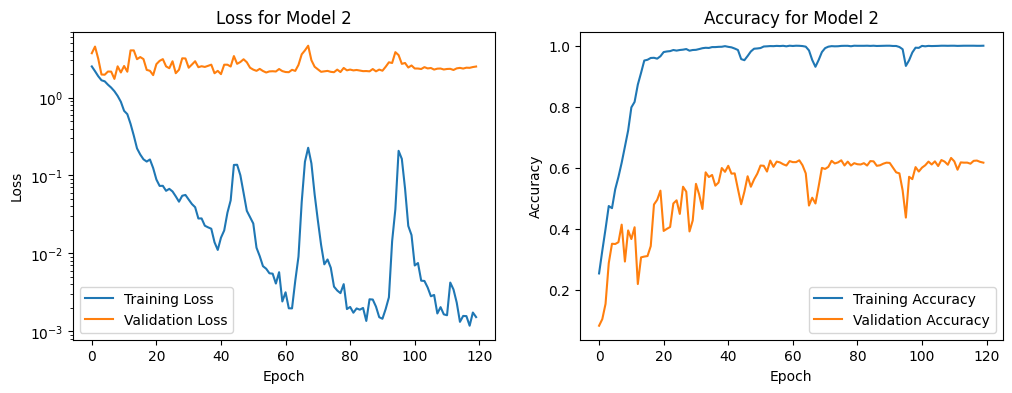

In [ ]:
plot_learning_curves(history2, 'Model 2')

In [ ]:
# Evaluate the model
loss, acc = model2.evaluate(test_ds, verbose=2)
print("Model, accuracy: {:5.2f}%".format(100 * acc))
print("Model, loss: {:5.2f}%".format(100 * loss))

38/38 - 1s - 14ms/step - accuracy: 0.6300 - loss: 2.5564
Model, accuracy: 63.00%
Model, loss: 255.64%


2024-05-17 16:48:31.235086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Classification Report for Model 2:
              precision    recall  f1-score   support

   F_fifties       0.59      0.73      0.65       100
  F_fourties       0.73      0.57      0.64       100
   F_sixties       0.86      0.87      0.87       100
     F_teens       0.62      0.71      0.66       100
  F_thirties       0.61      0.56      0.58       100
  F_twenties       0.56      0.49      0.52       100
   M_fifties       0.70      0.70      0.70       100
  M_fourties       0.51      0.47      0.49       100
   M_sixties       0.95      0.93      0.94       100
     M_teens       0.62      0.55      0.59       100
  M_thirties       0.38      0.43      0.40       100
  M_twenties       0.49      0.55      0.52       100

    accuracy                           0.63      1200
   macro avg       0.64      0.63      0.63      1200
weighted avg       0.64      0.63      0.63      1200



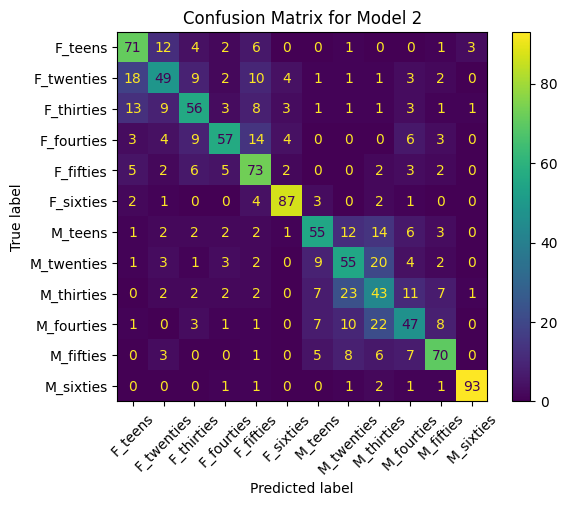

<Figure size 4400x4400 with 0 Axes>

In [ ]:
print_confusion_matrix_and_report(model2, test_ds, 'Model 2')

In [139]:
KERAS_MODEL_PATH = 'tf_model_2'

model2.export(KERAS_MODEL_PATH)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(KERAS_MODEL_PATH) # path to the SavedModel directory

tflite_model = converter.convert()

# Save the model.
with open('model_2.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: tf_model_2/assets


INFO:tensorflow:Assets written to: tf_model_2/assets


Saved artifact at 'tf_model_2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor_610')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  123201203812128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123201203812656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123201203814240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123200752330352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123201203814064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123201203811248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123200743747424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123200743498672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123200744341168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123200744341344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1232007434995

W0000 00:00:1715989576.797899    3941 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1715989576.797920    3941 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-05-17 19:46:16.798106: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: tf_model_2
2024-05-17 19:46:16.799657: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-17 19:46:16.799673: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: tf_model_2
2024-05-17 19:46:16.833516: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-05-17 19:46:16.965389: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: tf_model_2
2024-05-17 19:46:16.999418: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 201315 microseconds.


## Model 3

In [140]:
# https://link.springer.com/article/10.1007/s11042-021-11614-4/tables/1
# https://link.springer.com/article/10.1007/s11042-021-11614-4/tables/2

def preprocess_block(inputs, block_name):
    with tf.name_scope(block_name):
        # from 3 channels to 1 channel, rgb to greyscale
        x = layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x), name=f"{block_name}_greyscale")(inputs)
        x = layers.Resizing(64, 64)(x)
        x = layers.Rescaling(1./255)(x)
    return x

def flb_block_2(inputs, block_name):
    with tf.name_scope(block_name):
        x = layers.Conv2D(48, (3, 3), padding='same', activation='relu')(inputs)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(24, (3, 3), padding='same', activation='relu')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
    return x

def gru_block(inputs, block_name):
    with tf.name_scope(block_name):
        x = layers.GRU(112, activation='tanh', recurrent_activation='sigmoid', return_sequences=False)(inputs)
    return x

def output_block(inputs, block_name):
    with tf.name_scope(block_name):
        x = layers.Dropout(0.5)(inputs)
        x = layers.Dense(12, activation='sigmoid')(x)
    return x

input_layer = Input(shape=(None, None, 3))
prepro = preprocess_block(input_layer, "preprocess")
FLB2_1 = flb_block_2(prepro, "FLB_1")
R = layers.Reshape((-1, FLB2_1.shape[-2]*FLB2_1.shape[-1]))(FLB2_1)
GRU = gru_block(R, "GRU")
OUT = output_block(GRU, "FCN")

model3 = models.Model(inputs=input_layer, outputs=OUT)

model3.summary()

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess_greyscale (Lambda)   │ (None, None, None, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_26 (Resizing)          │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_26 (Rescaling)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 48)     │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 24)     │        10,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, 16, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 16, 384)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 112)            │       167,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 12)             │         1,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,556 (701.39 KB)

 Trainable params: 179,556 (701.39 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [142]:
history3 = model3.fit(
    train_ds,
    steps_per_epoch=cv_17['train'].num_rows // BATCH_SIZE,
    epochs=120, 
    validation_data=val_ds,
    validation_steps=cv_17['val'].num_rows // BATCH_SIZE,
    verbose=2
)

Epoch 1/120
112/112 - 5s - 43ms/step - accuracy: 0.1727 - loss: 2.2889 - val_accuracy: 0.0836 - val_loss: 2.7752
Epoch 2/120
112/112 - 3s - 28ms/step - accuracy: 0.1749 - loss: 2.2738 - val_accuracy: 0.0848 - val_loss: 2.7599
Epoch 3/120
112/112 - 3s - 30ms/step - accuracy: 0.1785 - loss: 2.2393 - val_accuracy: 0.0865 - val_loss: 2.6163
Epoch 4/120
112/112 - 3s - 31ms/step - accuracy: 0.1956 - loss: 2.1595 - val_accuracy: 0.1875 - val_loss: 2.3570
Epoch 5/120
112/112 - 4s - 33ms/step - accuracy: 0.2295 - loss: 2.0875 - val_accuracy: 0.1807 - val_loss: 2.2867
Epoch 6/120
112/112 - 3s - 31ms/step - accuracy: 0.2752 - loss: 1.9334 - val_accuracy: 0.2346 - val_loss: 2.0890
Epoch 7/120
112/112 - 3s - 31ms/step - accuracy: 0.3142 - loss: 1.8653 - val_accuracy: 0.3074 - val_loss: 1.9544
Epoch 8/120
112/112 - 3s - 29ms/step - accuracy: 0.3346 - loss: 1.7637 - val_accuracy: 0.3416 - val_loss: 1.8576
Epoch 9/120
112/112 - 3s - 29ms/step - accuracy: 0.3529 - loss: 1.7343 - val_accuracy: 0.3639 - 

In [143]:
model3.save_weights('./checkpoints/model3_grey.weights.h5')

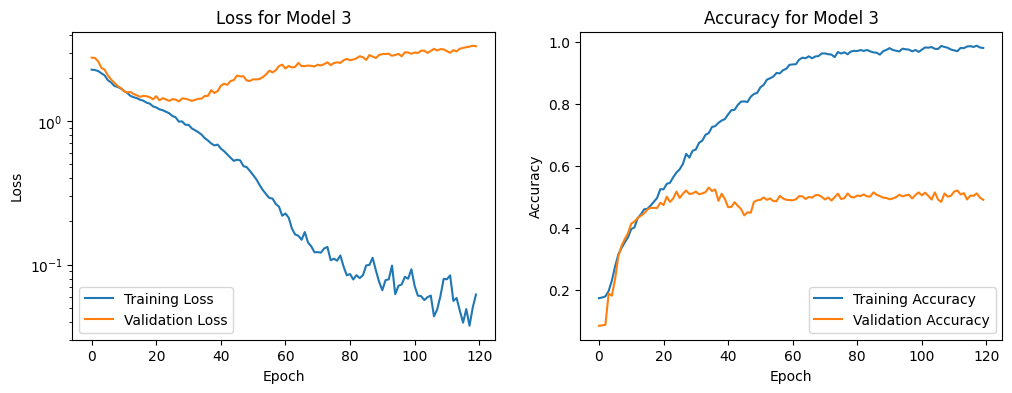

In [144]:
plot_learning_curves(history3, 'Model 3')

In [145]:
# Evaluate the model
loss2, acc2 = model3.evaluate(test_ds, verbose=2)
print("Model, accuracy: {:5.2f}%".format(100 * acc2))
print("Model, loss: {:5.2f}%".format(100 * loss2))

38/38 - 1s - 17ms/step - accuracy: 0.4983 - loss: 3.3934
Model, accuracy: 49.83%
Model, loss: 339.34%


 6/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

2024-05-17 19:52:52.587296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Classification Report for Model 3:
              precision    recall  f1-score   support

   F_fifties       0.52      0.44      0.48       100
  F_fourties       0.50      0.51      0.51       100
   F_sixties       0.85      0.71      0.77       100
     F_teens       0.57      0.42      0.48       100
  F_thirties       0.36      0.39      0.38       100
  F_twenties       0.42      0.47      0.44       100
   M_fifties       0.50      0.74      0.60       100
  M_fourties       0.37      0.42      0.39       100
   M_sixties       0.83      0.92      0.87       100
     M_teens       0.49      0.33      0.39       100
  M_thirties       0.28      0.30      0.29       100
  M_twenties       0.37      0.33      0.35       100

    accuracy                           0.50      1200
   macro avg       0.50      0.50      0.50      1200
weighted avg       0.50      0.50      0.50      1200



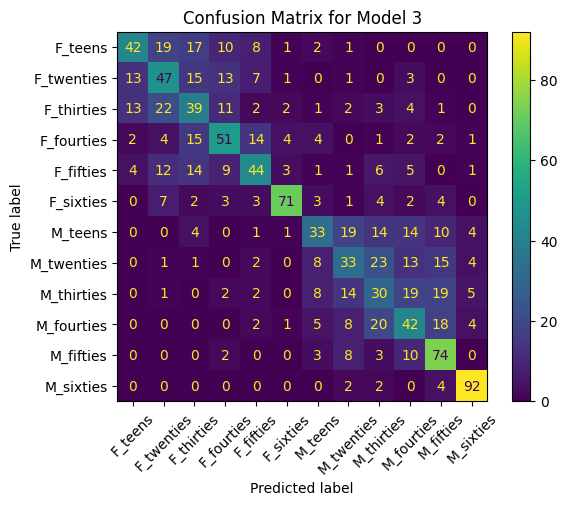

<Figure size 4400x4400 with 0 Axes>

In [146]:
print_confusion_matrix_and_report(model3, test_ds, 'Model 3')

In [147]:
KERAS_MODEL_PATH = 'tf_model_3'

model3.export(KERAS_MODEL_PATH)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(KERAS_MODEL_PATH) # path to the SavedModel directory

tflite_model = converter.convert()

# Save the model.
with open('model_3.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: tf_model_3/assets


INFO:tensorflow:Assets written to: tf_model_3/assets


Saved artifact at 'tf_model_3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor_636')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  123200744322672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123200744322848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123200703325984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123200700670192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123200698934896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123200698934544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123200698933488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123200698964272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123200698964096: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1715989974.516848    3941 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1715989974.516868    3941 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-05-17 19:52:54.517063: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: tf_model_3
2024-05-17 19:52:54.517746: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-17 19:52:54.517761: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: tf_model_3
2024-05-17 19:52:54.530708: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-05-17 19:52:54.570762: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: tf_model_3
2024-05-17 19:52:54.584839: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 67768 microseconds.
loc(callsite(callsite(fused["CudnnRNNV3:", "functional_51_1/gru

ConverterError: Could not translate MLIR to FlatBuffer.<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_51_1/gru_11_1/CudnnRNNV3@__inference___call___511353"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper___call___511400"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_51_1/gru_11_1/CudnnRNNV3@__inference___call___511353"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper___call___511400"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops in the model are custom ops, See instructions to implement custom ops: https://www.tensorflow.org/lite/guide/ops_custom 
Custom ops: CudnnRNNV3
Details:
	tf.CudnnRNNV3(tensor<?x16x384xf32>, tensor<?x1x112xf32>, tensor<f32>, tensor<167328xf32>, tensor<?xi32>) -> (tensor<?x16x112xf32>, tensor<?x1x112xf32>, tensor<f32>, tensor<*xf32>, tensor<*xi8>) : {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "gru", seed = 0 : i64, seed2 = 0 : i64, time_major = false}

